## Example for LOO-PIT, K-hat and ELPD difference plots

In [1]:
%load_ext watermark
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

from hierarchical_bayes_nmr_validation import *

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = "1UBQ"
protein2 = '1D3Z'
bmrb_code = '6457'
marker = 'x'
samples = 2000

In [4]:
# CS data is collected for every protein in a single dataframe
dataframe_ubq = get_biomolecular_data(protein1, bmrb_code)
dataframe_d3z = get_biomolecular_data(protein2, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)
/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [5]:
# run hierarchical bayesian linear regression for each protein 
dataframe_reference_ubq, idata_reference_ubq = hierarchical_reg_reference(target_df=dataframe_ubq, samples=2000)
dataframe_reference_d3z, idata_reference_d3z = hierarchical_reg_reference(target_df=dataframe_d3z, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α, sigma_sd, beta_sd, alpha_sd]


/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 168 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α, sigma_sd, beta_sd, alpha_sd]


/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 168 seconds.


In [6]:
idata_ubq = idata_reference_ubq.sel(
    cheshift_dim_0=slice(dataframe_reference_ubq.shape[0]-dataframe_ubq.shape[0], dataframe_reference_ubq.shape[0]))

In [7]:
idata_d3z = idata_reference_d3z.sel(
    cheshift_dim_0=slice(dataframe_reference_d3z.shape[0]-dataframe_d3z.shape[0], dataframe_reference_d3z.shape[0]))

# LOO

<ipython-input-8-247d28f5853d>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


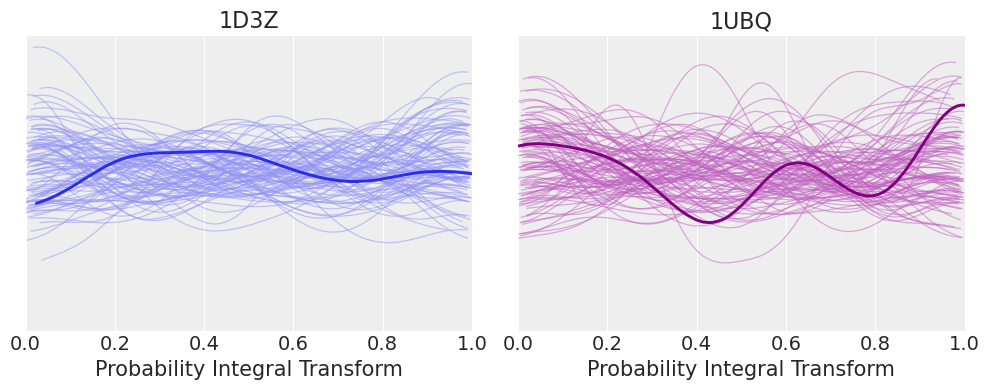

In [8]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_d3z, y="cheshift", legend=False, ax=ax[0])
az.plot_loo_pit(idata_ubq, y="cheshift", legend=False, ax=ax[1], color='purple')
ax[0].set_title(protein2)
ax[1].set_title(protein1)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_loo_pit.png")

# Khat

In [10]:
# compute LOO separately
loo_ubq = az.loo(idata_ubq, pointwise=True)
loo_d3z = az.loo(idata_d3z, pointwise=True)

<ipython-input-11-695f0f3dc273>:31: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


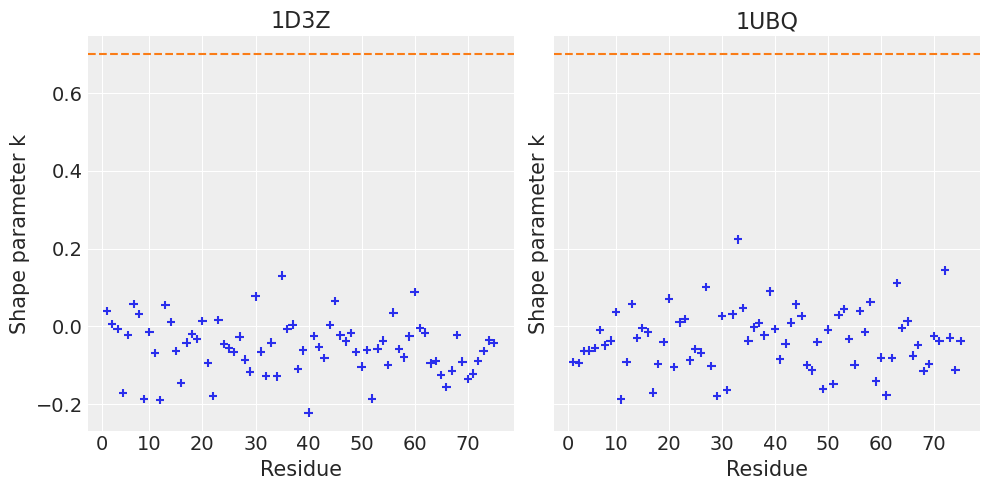

In [11]:
# Plot K-hat
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

az.plot_khat(loo_d3z, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_ubq, hlines_kwargs={"alpha":0}, ax=ax[1])

da_d3z = dataframe_d3z.res[loo_d3z.pareto_k.values > 0.7]
xs_d3z = da_d3z.index.values + 1
text_d3z = [a + " " + str(b) for a, b in zip(da_d3z, xs_d3z)]
ys_d3z = loo_d3z.pareto_k[loo_d3z.pareto_k > 0.7].values

for tx, x, y in zip(text_d3z, xs_d3z, ys_d3z):
    ax[0].annotate(tx, (x + 0.5 - dataframe_d3z.index[0], y))
    
da_ubq = dataframe_ubq.res[loo_ubq.pareto_k.values > 0.7]
xs_ubq = da_ubq.index.values +1
text_ubq = [a + " " + str(b) for a, b in zip(da_ubq, xs_ubq)]
ys_ubq = loo_ubq.pareto_k[loo_ubq.pareto_k > 0.7].values

for tx, x, y in zip(text_ubq, xs_ubq, ys_ubq):
    ax[1].annotate(tx, (x + 0.5 - dataframe_ubq.index[0], y))

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
[ax[i].set_xticks([-1, 8, 18, 28, 38, 48, 58, 68]) for i in range(len(ax))]
[ax[i].set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70']) for i in range(len(ax))]

[ax[i].set_title(protein) for i, protein in enumerate([protein2, protein1])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_khat.png")

# ELPD

In [12]:
# compute ELPD difference
loo_ubq = az.loo(idata_ubq, pointwise=True).loo_i.values
loo_d3z = az.loo(idata_d3z, pointwise=True).loo_i.values
elpd = loo_d3z - loo_ubq

/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/elpdplot.py:106: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.autofmt_xdate()


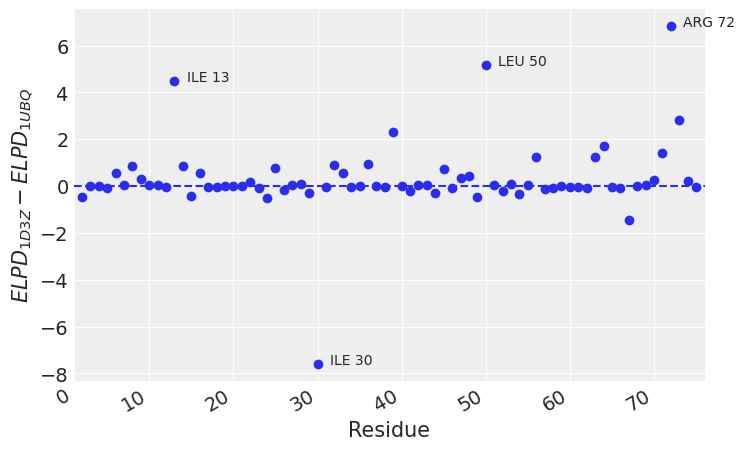

In [13]:
# plot ELPD difference
ax = az.plot_elpd({"1D3Z": idata_d3z, "1UBQ": idata_ubq}, xlabels=True)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel('$ELPD_{1D3Z}-ELPD_{1UBQ}$')
ax.set_xlim(1, len(dataframe_ubq))
ax.set_xticks([-1, 8, 18, 28, 38, 48, 58, 68])
ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70'])
ax.set_title('')
da_ubq_1 = dataframe_ubq.res[elpd > 4]
da_ubq_2 = dataframe_ubq.res[elpd < -4]
da_ubq = pd.concat([da_ubq_1, da_ubq_2])
xs_ubq = da_ubq.index.values+1
text_ubq = [a + " " + str(b) for a, b in zip(da_ubq, xs_ubq)]
ys_ubq = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text_ubq, xs_ubq, ys_ubq):
    ax.annotate(tx, (x + 0.5 - dataframe_ubq.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight");

In [14]:
%watermark -v -m -p numpy,matplotlib,pymc3,arviz

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

numpy     : 1.19.2
matplotlib: 3.3.2
pymc3     : 3.11.0
arviz     : 0.11.0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-693.5.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

